<a href="https://colab.research.google.com/github/dsikar/transfer-report-jupyter-notebooks/blob/main/RGBShiftPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run predictions with shifting data distributions
## Clone code and prepare data

In [ ]:
!git clone https://github.com/dsikar/sdsandbox
%cd  sdsandbox/src/
!tar xvf examples/logs_Wed_Nov_25_23_39_22_2020.tar.gz
# remove "bad" image
!rm logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg

In [ ]:
def GetJSONSteeringAngles(filemask):
    """
    Get steering angles stored as 'user/angle' attributes in .json files
    Inputs:
        filemask: string, path and mask
    Outputs
        svals: list, steering values
    """
    import os 
    import fnmatch       
    filemask = os.path.expanduser(filemask)
    path, mask = os.path.split(filemask)

    matches = []
    for root, dirnames, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, mask):
            matches.append(os.path.join(root, filename))
    # sort by create date
    # matches = sorted(matches, key=os.path.getmtime)
    # sort by filename prefix
    matches = sort_sdsandbox_files(matches)
    # steering values
    svals = []
    for fullpath in matches:
      # print(fullpath)
      frame_number = os.path.basename(fullpath).split("_")[0]
      json_filename = os.path.join(os.path.dirname(fullpath), "record_" + frame_number + ".json")
      jobj = load_json(json_filename)
      svals.append(jobj['user/angle'])
    return svals

def load_json(filepath):
    """
    Load a json file
    Inputs
        filepath: string, path to file
    Outputs
        data: dictionary, json key, value pairs
    Example
    path = "~/git/msc-data/unity/roboRacingLeague/log/logs_Sat_Nov_14_12_36_16_2020/record_11640.json"
    js = load_json(path)
    """
    import json
    with open(filepath, "rt") as fp:
        data = json.load(fp)
    return data 

def sort_sdsandbox_files(matches):
  """
  Sort sdsandbox files in format e.g. 'logs_Wed_Nov_25_23_39_22_2020/1339_cam-image_array_.jpg'
  This is to emulate a sort-by-date feature, once files have been copied and datetime stamp is lost

  Parameters
  -------
  matches: list of strings, image filepaths

  Output
  -------
  sorted_matches: list of strings, sorted list

  Example
  -------
  matches = sort_sdsandbox_files(matches)
  for match in matches:
    print(match)
  """
  filenums = {}
  sorted_matches = []
  for match in matches:
    # match ~ 'logs_Wed_Nov_25_23_39_22_2020/1339_cam-image_array_.jpg'
    # match.split('/')[-1].split('_')[0] ~ 1339
    filenums[int(match.split('/')[-1].split('_')[0])] = match

  filenums = sorted(filenums.items(), key=lambda filenums: filenums[0])
  for key in filenums:
    sorted_matches.append(key[1]) 

  return sorted_matches        

def GetPredictions(filemask, modelpath, datashift = 0, modelname = 'nvidia2'):
    """
    Get predictions of a given model
    
    Parameters
    -------
        filemask: string, path of the images to generate steering angle predictions
        modelpath: string, path of the trained model 
        datashift: integer, RGB intensity mean shift to left (negative) or right (positive) or 
        input image RGB intensity mean
        modelname: string, model name refering to input geometry to use
    
    Output
    -------
        predictions: numpy array of floats, steering angle predictons
        
    Example:
    filemask = '../../../../Downloads/dataset/unity/genTrack/genTrackOneLap/logs_Wed_Nov_25_23_39_22_2020/*.jpg'
    modelpath = '../../../../Downloads/trained_models/nvidia2/20201207192948_nvidia2.h5'
    datashift = -10
    filename = 'nvidia2'
    
    p = GetPredictions(filemask, modelpath, datashift)
    
    """
    import os
    from tensorflow.python.keras.models import load_model
    import cv2
    import Augment_cls    
    import fnmatch
    from PIL import Image
    import numpy as np
    import sys # for exception handling

    ag = Augment_cls.Augment_cls(modelname)

    model = load_model(modelpath)
    model.compile("sgd", "mse")
    
    filemask = os.path.expanduser(filemask)
    path, mask = os.path.split(filemask)

    matches = []
    for root, dirnames, filenames in os.walk(path):
        for filename in fnmatch.filter(filenames, mask):
            matches.append(os.path.join(root, filename))
    # sort by create date
    matches = sorted(matches, key=os.path.getmtime)
    # sort by filename prefix
    matches = sort_sdsandbox_files(matches)

    # steering values
    svals = []
    for fullpath in matches: 
      try:
        image = Image.open(fullpath)
        #PIL Image as a numpy array
        image = np.array(image, dtype=np.float32)
        # shift distribution
        image, rgbmean, rgbstd, rgbvar = shiftRGBValues(image, datashift, datashift, datashift)   
        # keep data type for prediction model
        image = np.array(image, dtype=np.float32)   
        image = ag.preprocess(image)
        image = image.reshape((1,) + image.shape)

        mod_pred = model.predict(image)   
        svals.append(mod_pred)

      except:
        print("Error ", sys.exc_info()[0], " occurred processing image ", fullpath, ", skipping") 
        pass

    preds = []
    # only return steering angles
    for i in range(0, len(svals)):
      preds.append(svals[i][0][0])      
    return preds  


# change rgb values
# https://stackoverflow.com/questions/59320564/how-to-access-and-change-color-channels-using-pil
def shiftRGBValues(img, rv=0, gv=0, bv=0):
  """
  Shift RGB values using PIL, and return mean and standard deviations

  Parameters
  -------
    img: uint8 numpy image array
    rv: integer, value to be added to red channel
    gv: integer, value to be added to green channel
    bv, integer, value to be added to blue channel

  Output
  -------
    myimg: uint8 numpy image array
    rgbmean: float, rgb mean
    rgbstd: float, rgb standard deviation
    rgbvar: float, rgb variance

  Example
  -------
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  img = mpimg.imread('steph.jpeg')
  myimg, rgbmean, rgbstd, rgbvar = changeRGB(img, 60, 0, 0)
  plt.imshow(myimg)
  """
  from PIL import Image
  import numpy as np

  im = Image.fromarray(np.uint8(img))

  # Split into 3 channels
  r, g, b = im.split()

  # Red
  r = r.point(lambda i: i + rv)

  # Green
  g = g.point(lambda i: i + gv)

  # Blue
  b = b.point(lambda i: i + bv)

  # Recombine back to RGB image
  result = Image.merge('RGB', (r, g, b))

  rgbmean = np.mean(result) 
  rgbstd = np.std(result) 
  rgbvar = np.var(result) 
  # Convert to uint8 numpy array
  myimg = np.asarray(result)

  return myimg, rgbmean, rgbstd, rgbvar    

# TODO Rename gos steer_error, Steering Error, average error over a set of predictions in degrees
def gos(p, g, n):
    """
    Calculate the goodness-of-steer between a prediction and a ground truth array.
    Inputs
        p: array of floats, steering angle prediction
        g: array of floats, steering angle ground truth.
        n: float, normalization constant
    Output
        gos: float, average of absolute difference between ground truth and prediction arrays
    """
    # todo add type assertion
    assert len(p) == len(g), "Arrays must be of equal length"
    return sum(abs(p - g)) / len(p) * n
    # print("Goodness of steer: {:.2f}".format(steer))

In [ ]:
# runtime 1 minute, 1.4k predictions
filemask = 'logs_Wed_Nov_25_23_39_22_2020/*.jpg'
modelpath = 'examples/20201207192948_nvidia2.h5'
modelname = 'nvidia2'
datashift = 120
# p = GetPredictions(filemask, modelpath, datashift, modelname)
# pPlus80 = GetPredictions(filemask, modelpath, datashift, modelname)
pPlus120 = GetPredictions(filemask, modelpath, datashift, modelname)
# Error with path: logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg
print("type(pPlus120):", type(pPlus120))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:1055: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


type(pPlus120): <class 'list'>


# Generate data

In [ ]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
print("******************")
print("Start time:",date_time)	

filemask = 'logs_Wed_Nov_25_23_39_22_2020/*.jpg'
modelpath = 'examples/20201207192948_nvidia2.h5'
modelname = 'nvidia2'

# datashift values to test
pMinus120 = 0
pMinus80 = 1
pMinus40 = 2
pMinus0 = 3
pPlus40 = 4
pPlus80 = 5
pPlus120 = 6

datashifts = [-120,-80,-40,0,40,80,120]
results = []
for val in datashifts:
  print("Processing shift: {}".format(str(val)))
  res = GetPredictions(filemask, modelpath, val, modelname)
  results.append(res)
now = datetime.now()
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
print("******************")
print("End time:",date_time)	  

******************
Start time: 06/26/2022, 18:52:54
Processing shift: -120


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/core.py:1055: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


Processing shift: -80
Processing shift: -40
Processing shift: 0
Processing shift: 40
Processing shift: 80
Processing shift: 120
******************
End time: 06/26/2022, 18:59:47


# Cleanup
To avoid error when computing steering errors

In [ ]:
!rm logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg

rm: cannot remove 'logs_Wed_Nov_25_23_39_22_2020/0_cam-image_array_.jpg': No such file or directory


# Convert to Numpy arrays

In [ ]:
import numpy as np
for i in range (0, len(results)):
  results[i] = np.array(results[i])

# Data shift steering error average

In [ ]:
sterr = []
# ground truth
g = GetJSONSteeringAngles(filemask)
g = np.asarray(g)
nc = 25 # maximum steering angle / normalisation constant
for i in range (0, len(results)):
  steer_err = gos(results[i],g,nc)
  sterr.append(steer_err)
  strline = "Steering error average for data shift = {}: {}".format(str(datashifts[i]), str(steer_err))
  print(strline)

Steering error average for data shift = -120: 1.8432540957430164
Steering error average for data shift = -80: 1.7000205273693305
Steering error average for data shift = -40: 1.694793940333196
Steering error average for data shift = 0: 1.6829038607492623
Steering error average for data shift = 40: 1.9145348848815178
Steering error average for data shift = 80: 2.6942793829939564
Steering error average for data shift = 120: 3.6825313317011763


# Plot graphs
## Negative 120, 80, 40 and 0

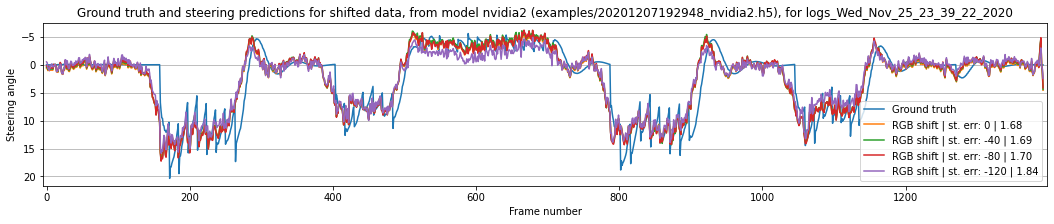

In [ ]:
import os
import fnmatch
import json
import matplotlib.pyplot as plt
# plot ground truth steering angles for
# filemask = 'logs_Wed_Nov_25_23_39_22_2020/*.jpg'
nc = 25 # norm. constant, maximum steering angle in degrees

g = GetJSONSteeringAngles(filemask)
g = np.asarray(g)

plt.rcParams["figure.figsize"] = (18,3)

plt.plot(g*nc, label='Ground truth')
res = "{:.2f}".format(sterr[pMinus0])
plt.plot(results[pMinus0]*nc, label='RGB shift | st. err: 0 | ' + res)
res = "{:.2f}".format(sterr[pMinus40])
plt.plot(results[pMinus40]*nc, label='RGB shift | st. err: -40 | ' + res)
res = "{:.2f}".format(sterr[pMinus80])
plt.plot(results[pMinus80]*nc, label='RGB shift | st. err: -80 | ' + res)
res = "{:.2f}".format(sterr[pMinus120])
plt.plot(results[pMinus120]*nc, label='RGB shift | st. err: -120 | ' + res)

plt.ylabel('Steering angle')
plt.xlabel('Frame number')    
# Set a title of the current axes.
modelstr = modelname + ' (' + modelpath + ')'

#pMinus120 = 0
#pMinus80 = 1
#pMinus40 = 2
#pMinus0 = 3
#pPlus40 = 4
#pPlus80 = 5
#pPlus120 = 6
#datashifts = [-120,-80,-40,0,40,80,120]
#results

mytitle = 'Ground truth and steering predictions for shifted data, from model ' + modelstr + ', ' + 'for logs_Wed_Nov_25_23_39_22_2020'
plt.title(mytitle)
plt.grid(axis='y')
# set limit
plt.xlim([-5,len(g)+5])
plt.gca().invert_yaxis()
plt.legend(loc='lower right')
plt.show()

## Positive 40, 80, 120

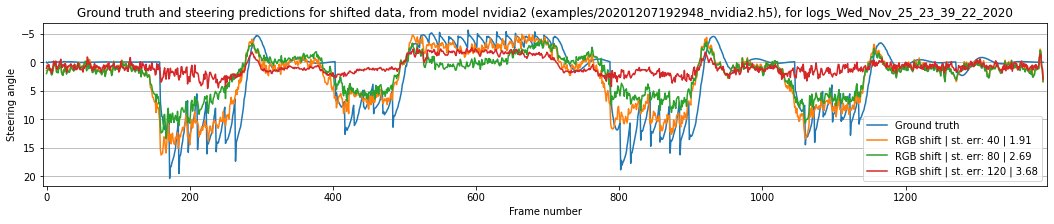

In [ ]:
plt.rcParams["figure.figsize"] = (18,3)

plt.plot(g*nc, label='Ground truth')
#plt.plot(results[pMinus0]*nc, label='RGB shift: 0')
res = "{:.2f}".format(sterr[pPlus40])
plt.plot(results[pPlus40]*nc, label='RGB shift | st. err: 40 | ' + res)
res = "{:.2f}".format(sterr[pPlus80])
plt.plot(results[pPlus80]*nc, label='RGB shift | st. err: 80 | ' + res)
res = "{:.2f}".format(sterr[pPlus120])
plt.plot(results[pPlus120]*nc, label='RGB shift | st. err: 120 | ' + res)

plt.ylabel('Steering angle')
plt.xlabel('Frame number')    
# Set a title of the current axes.
modelstr = modelname + ' (' + modelpath + ')'

#pMinus120 = 0
#pMinus80 = 1
#pMinus40 = 2
#pMinus0 = 3
#pPlus40 = 4
#pPlus80 = 5
#pPlus120 = 6
#datashifts = [-120,-80,-40,0,40,80,120]
#results

mytitle = 'Ground truth and steering predictions for shifted data, from model ' + modelstr + ', ' + 'for logs_Wed_Nov_25_23_39_22_2020'
plt.title(mytitle)
plt.grid(axis='y')
# set limit
plt.xlim([-5,len(g)+5])
plt.gca().invert_yaxis()
plt.legend(loc='lower right')
plt.show()

# Data shift steering error average

In [ ]:
sterr = []
for i in range (0, len(results)):
  steer_err = gos(results[i],g,nc)
  sterr.append(steer_err)
  strline = "Steering error average for data shift = {}: {}".format(str(datashifts[i]), str(steer_err))
  print(strline)

Steering error average for data shift = -120: 1.8432540957430164
Steering error average for data shift = -80: 1.7000205273693305
Steering error average for data shift = -40: 1.694793940333196
Steering error average for data shift = 0: 1.6829038607492623
Steering error average for data shift = 40: 1.9145348848815178
Steering error average for data shift = 80: 2.6942793829939564
Steering error average for data shift = 120: 3.6825313317011763


In [ ]:
def listSteeringBins(svals, pname="output", save=True, nc=25, rmout=0):
    """
    Plot a steering values' histogram
    Inputs
        svals: list, array of normalized steering values
        pname: string, output plot name
        save: boolean, save plot to disk
        nc: int, normalization constant, used in the simulator to put angles in range
        -1, 1. Default is 25.
        rmout: integer, outlier range to remove
    Outputs
        none
    """
    svalscp = [element * nc for element in svals]
    values = len(svals)
    
    # remove outliers
    if(rmout>0):
        #my_iterator = filter(lambda svalscp: svalscp <= rmout and svalscp >= (-1 * rmout), svalscp)
        #svalsrmout = list(my_iterator)
        #svalscp = svalsrmout
        #values = len(svalsrmout)
        #print("Removed {} records".format(len(svals) - len(svalsrmout)))
        #svals = svalsrmout
        svals = removeOutliers(svalscp, rmout, nc)
        values = len(svals)
    mean = ("%.2f" % statistics.mean(svalscp))
    std = ("%.2f" % statistics.stdev(svalscp))
    plt.title=(pname)
    # NB Plotted as normalized histogram
    sns.distplot(svalscp, bins=nc*2, kde=False, norm_hist=True, 
    axlabel= pname + ' steer. degs. norm. hist. ' + str(values) + ' values, mean = ' + mean + ' std = ' + std)
    #if(save):
    #    sns.save("output.png")
    if(save):
        plt.savefig(pname + '.png')
    plt.show()

listSteeringBins(preds)

NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


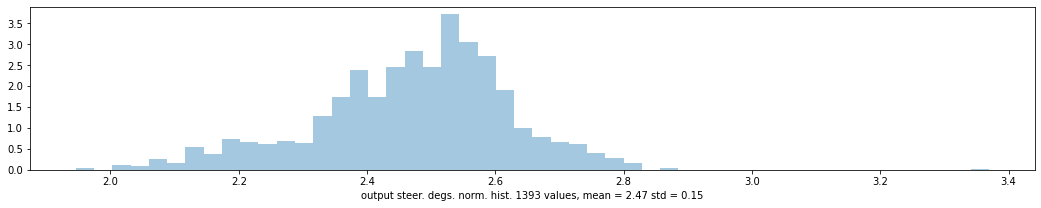

In [ ]:
listSteeringBins(preds)

# Positive steering angle example, labelled dataset

In [ ]:
# 1105_cam-image_array_.jpg
#!ls logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg
# !ls logs_Wed_Nov_25_23_39_22_2020/*1105*
!cat logs_Wed_Nov_25_23_39_22_2020/record_1105.json
# {"cam/image_array":"1105_cam-image_array_.jpg","user/throttle":0.0,"user/angle":0.31525176763534548,"user/mode":"user","track/lap":0,"track/loc":21}
# 0.31525176763534548 * 25 = 7.88129419088 ~ 7.9 degrees

{"cam/image_array":"1105_cam-image_array_.jpg","user/throttle":0.0,"user/angle":0.31525176763534548,"user/mode":"user","track/lap":0,"track/loc":21}

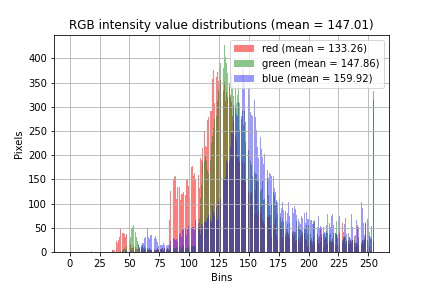

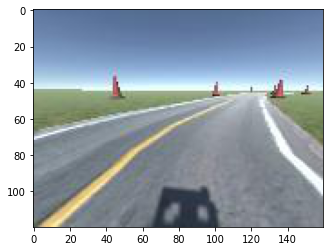

In [ ]:
from utils.utils import plot_img_hist # need utils.py
from PIL import Image
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
imgpath = 'logs_Wed_Nov_25_23_39_22_2020/1105_cam-image_array_.jpg'
image = Image.open(imgpath)
plt.rcParams["figure.figsize"] = (6,4)
plt.imshow(image)
myfig = plot_img_hist(image)
myplot = mpimg.imread('temp_plot.jpg')
# correct channels
b,g,r = cv2.split(myplot)
myplot = cv2.merge([r,g,b])
cv2_imshow(myplot)

In [ ]:
# convert image to array and print shape
#image = np.array(image)
print(type(image)) # <class 'numpy.ndarray'>
print(image.shape) # (120, 160, 3)

<class 'PIL.JpegImagePlugin.JpegImageFile'>


AttributeError: ignored

# Shift and plot +100 RGB mean

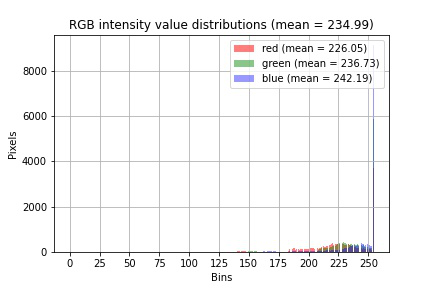

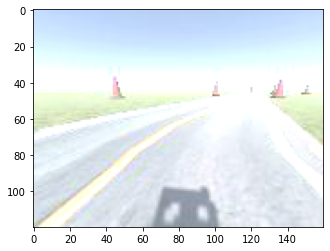

In [ ]:
# image = Image.open(imgpath)
datashift = 100
image = Image.open(imgpath)
imageshifted, rgbmean, rgbstd, rgbvar = shiftRGBValues(image, datashift, datashift, datashift)
plt.imshow(imageshifted)
image = imageshifted
plt.rcParams["figure.figsize"] = (6,4)
myfig = plot_img_hist(image)
myplot = mpimg.imread('temp_plot.jpg')
# correct channels
b,g,r = cv2.split(myplot)
myplot = cv2.merge([r,g,b])
cv2_imshow(myplot)

# Shift and plot -100 RGB mean

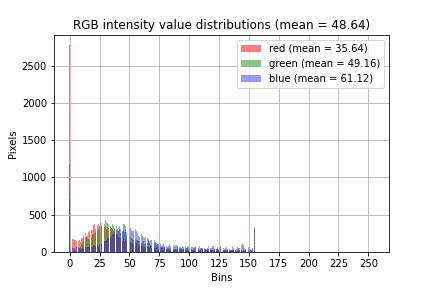

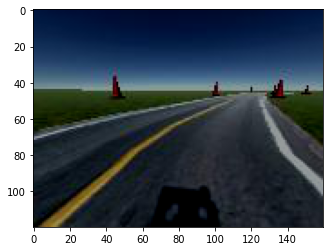

In [ ]:
# image = Image.open(imgpath)
datashift = -100
image = Image.open(imgpath)
imageshifted, rgbmean, rgbstd, rgbvar = shiftRGBValues(image, datashift, datashift, datashift)
plt.imshow(imageshifted)
image = imageshifted
myfig = plot_img_hist(image)
plt.rcParams["figure.figsize"] = (6,4)
myplot = mpimg.imread('temp_plot.jpg')
# correct channels
b,g,r = cv2.split(myplot)
myplot = cv2.merge([r,g,b])
cv2_imshow(myplot)

# Statistical Distances
## Relative entropy

$
D_\text{KL}(P \parallel Q) = \sum_{x\in\mathcal{X}} P(x) \log\left(\frac{P(x)}{Q(x)}\right)
$

In [ ]:
from scipy.stats import entropy
print(entropy([1/2, 1/2], base=2))
print(entropy([1/2, 1/2], base=10))
# relative entropy
entropy([1/2, 1/2], qk=[9/10, 1/10])

1.0
0.30102999566398114


0.5108256237659907

In [ ]:
image
entropy(image[0], qk=image[0])

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2671: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


array([nan,  0.,  0.])

# Convert nan to zero

In [ ]:
red_channel = image[0][0]
red_channel[np.isnan(red_channel)] = 0
#entropy(red_channel, qk=red_channel)

ValueError: ignored

In [ ]:
type(red_channel) # numpy.ndarray
red_channel.shape # (3,)
image.shape #(120, 160, 3)
image[0].shape # (160, 3)
image[0][0].shape # (3,)
image[1].shape # (160, 3)
image
# array([[[ 0, 21, 61],
#        [ 0, 21, 61],
#        [ 0, 20, 60],
image[:,:,2]
# array([[61, 61, 60, ..., 61, 62, 62],
#       [61, 61, 61, ..., 62, 62, 63],
#       [62, 62, 62, ..., 63, 64, 64],

image[:,:,2].flatten()
# array([61, 61, 60, ..., 48, 43, 37], dtype=uint8)
blue_channel = image[:,:,2].flatten()
red_channel = image[:,:,0].flatten()
# relative entropy
entropy(red_channel, qk=red_channel) # 0.0
entropy(red_channel, qk=blue_channel) # inf

inf